**Project: Ensemble Learning on Modified MNIST with Dimensionality Reduction and Clustering**

*In this project, we train various classifiers on modified versions of the MNIST dataset, use ensemble methods to improve classification performance, reduce dimensionality for faster training and visualization, and explore clustering techniques on face datasets.*

# 1. Dataset Preparation

Firstly, we'll load and modify the MNIST dataset as well as split both the MNIST and Olivetti faces datasets into training, validation, and test sets.

In [ ]:
from sklearn.datasets import fetch_openml
from scipy.ndimage.interpolation import rotate
import numpy as np
import pandas as pd

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X_mnist, y_mnist = mnist["data"], mnist["target"].astype(np.int64)

# Define a function to apply transformations: rotate, flip, and darken
def modify_images(images):
    # Convert DataFrame to NumPy array if necessary
    if isinstance(images, pd.DataFrame):
        images = images.to_numpy()

    # Now you can reshape and modify the images as NumPy arrays
    rotated_images = rotate(images.reshape(-1, 28, 28), angle=25, axes=(1, 2), reshape=False).reshape(-1, 784)
    flipped_images = images.reshape(-1, 28, 28)[:, :, ::-1].reshape(-1, 784)
    darkened_images = images * 0.7

    return np.vstack([rotated_images, flipped_images, darkened_images])

# Apply transformations to the first 1000 images for demonstration
X_modified = modify_images(X_mnist[:1000])
y_modified = np.repeat(y_mnist[:1000], 3)  # Repeat labels for each transformation

# Append the modified images to the dataset
X_mnist_augmented = np.vstack([X_mnist, X_modified])
y_mnist_augmented = np.concatenate([y_mnist, y_modified])


<ipython-input-5-e2230727fb48>:2: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate
/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In the above block, we load the MNIST dataset and define a modify_images function that applies three types of image modifications: rotation, flipping, and darkening. We then apply these transformations to the first 1000 images for demonstration purposes, though in practice, we would likely modify more or even all images to enhance the robustness of our model. We concatenate these modified images and their labels to the original MNIST dataset, thereby augmenting our dataset to improve the model's generalization capabilities.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the augmented MNIST dataset
X_train_mnist, X_temp_mnist, y_train_mnist, y_temp_mnist = train_test_split(
    X_mnist_augmented, y_mnist_augmented, test_size=0.2, random_state=42, stratify=y_mnist_augmented
)
X_valid_mnist, X_test_mnist, y_valid_mnist, y_test_mnist = train_test_split(
    X_temp_mnist, y_temp_mnist, test_size=0.5, random_state=42, stratify=y_temp_mnist
)

# Load the Olivetti faces dataset
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces()
X_faces, y_faces = faces.data, faces.target

# Split the Olivetti faces dataset
X_train_faces, X_temp_faces, y_train_faces, y_temp_faces = train_test_split(
    X_faces, y_faces, test_size=0.4, random_state=42, stratify=y_faces
)
X_valid_faces, X_test_faces, y_valid_faces, y_test_faces = train_test_split(
    X_temp_faces, y_temp_faces, test_size=0.5, random_state=42, stratify=y_temp_faces
)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


Here, we split the augmented MNIST dataset into training, validation, and test sets, ensuring that we have a stratified split to maintain the original distribution of classes in all subsets. We do the same for the Olivetti faces dataset, which we also loaded. Stratification is crucial when splitting datasets with imbalanced classes to ensure that each subset reflects the overall composition.

# 2. Individual Classifiers and Ensemble

Next, we train individual classifiers on the MNIST dataset.



In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Initialize classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
et_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_classifier = SVC(kernel='linear', probability=True, max_iter=1000, tol=1e-3, random_state=42)
mlp_classifier = MLPClassifier(random_state=42)

# List of classifiers for easy iteration
classifiers = [rf_classifier, et_classifier, svm_classifier, mlp_classifier]

# Train each classifier
for clf in classifiers:
    clf.fit(X_train_mnist, y_train_mnist)

# Evaluate each classifier on the validation set
classifier_scores = {clf.__class__.__name__: clf.score(X_valid_mnist, y_valid_mnist) for clf in classifiers}
print(classifier_scores)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'RandomForestClassifier': 0.9363013698630137, 'ExtraTreesClassifier': 0.9378082191780822, 'SVC': 0.4456164383561644, 'MLPClassifier': 0.9008219178082192}


In the snippet above, we initialize four different classifiers: RandomForest, ExtraTrees, SVM, and MLP. We iterate through the list of classifiers, training each on the MNIST training set, and then evaluate them on the validation set. Using a dictionary comprehension allows us to store each classifier's accuracy in a readable and accessible way. We use SVC with probability=True instead of LinearSVC to enable probability estimates, which are required for soft voting in ensembles.

After training each of the classifiers, we observe the following validation scores: RandomForestClassifier achieves an accuracy of approximately 93.63%, ExtraTreesClassifier scores around 93.78%, SVC (with a linear kernel) significantly lags behind at about 44.56%, and MLPClassifier attains an accuracy close to 90.08%. These results suggest that while ensemble methods might have the potential to improve performance, particularly given the weak performance of the SVM, care should be taken with how much weight is given to the SVM's predictions in any ensemble approach.

Finally, we construct ensemble methods, including hard and soft voting, and a stacking ensemble.



In [ ]:
from sklearn.ensemble import VotingClassifier

# Creating a voting classifier with both hard and soft voting
voting_clf_hard = VotingClassifier(estimators=[
    ('rf', rf_classifier), ('et', et_classifier), ('svm', svm_classifier), ('mlp', mlp_classifier)],
    voting='hard'
)
voting_clf_soft = VotingClassifier(estimators=[
    ('rf', rf_classifier), ('et', et_classifier), ('svm', svm_classifier), ('mlp', mlp_classifier)],
    voting='soft'
)

# Fit both hard and soft voting classifiers
voting_clf_hard.fit(X_train_mnist, y_train_mnist)
voting_clf_soft.fit(X_train_mnist, y_train_mnist)

# Evaluate both classifiers
hard_voting_score = voting_clf_hard.score(X_valid_mnist, y_valid_mnist)
soft_voting_score = voting_clf_soft.score(X_valid_mnist, y_valid_mnist)
print(f"Hard Voting Score: {hard_voting_score}")
print(f"Soft Voting Score: {soft_voting_score}")


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Hard Voting Score: 0.9347945205479452
Soft Voting Score: 0.9278082191780822


Here, we create two voting classifiers for ensemble learning: one for hard voting and another for soft voting. Hard voting classifies based on the majority vote of the classifiers, while soft voting takes into account the confidence level of the predictions. We then fit these classifiers to the training data and evaluate their performance on the validation set.

The hard voting ensemble, which combines predictions based on a majority vote, achieves an accuracy of approximately 93.48% on the validation set, which is slightly lower than the best individual classifier. On the other hand, the soft voting ensemble, which accounts for the confidence of each classifier's predictions, yields about 92.78% accuracy. The decrease in performance with soft voting compared to hard voting might be due to the low accuracy of the SVM, which could be misleading the ensemble when its predictions are weighted by confidence.

In [ ]:
from sklearn.metrics import accuracy_score

# Create predictions for the validation set to train the blender
X_valid_predictions = np.array([clf.predict(X_valid_mnist) for clf in classifiers]).T

# Train the random forest as a blender on top of the other classifiers
blender_rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
blender_rf.fit(X_valid_predictions, y_valid_mnist)

# Out-of-bag score can be used as an estimation of the accuracy
print(f"OOB Score for Blender: {blender_rf.oob_score_}")

# Create predictions for the test set to evaluate the blender
X_test_predictions = np.array([clf.predict(X_test_mnist) for clf in classifiers]).T
y_pred_blender = blender_rf.predict(X_test_predictions)
blender_test_accuracy = accuracy_score(y_test_mnist, y_pred_blender)
print(f"Test Accuracy for Blender: {blender_test_accuracy}")


OOB Score for Blender: 0.9319178082191781
Test Accuracy for Blender: 0.9258904109589041


We prepare a stacking ensemble by using predictions from our base classifiers on the validation set to train a random forest blender. The out-of-bag (OOB) score serves as an estimate of the ensemble's performance. We then predict on the test set using the base classifiers and use these predictions to evaluate our blender's final performance.

The random forest blender, trained on the validation predictions of the base classifiers, exhibits an out-of-bag (OOB) score of approximately 93.19%. When this blender is evaluated on the test set, the stacking ensemble reaches an accuracy of about 92.59%. These results indicate that the blender is effectively integrating the base classifiers' predictions, but there is a slight overfitting to the validation set as evidenced by the slight drop in test accuracy.

In [ ]:
from sklearn.ensemble import StackingClassifier

# Initialize the stacking classifier
stack_clf = StackingClassifier(estimators=[
    ('rf', rf_classifier), ('et', et_classifier), ('svm', svm_classifier), ('mlp', mlp_classifier)],
    final_estimator=blender_rf
)

# Train the stacking classifier on the full training set and evaluate on the test set
stack_clf.fit(X_train_mnist, y_train_mnist)
stack_clf_score = stack_clf.score(X_test_mnist, y_test_mnist)
print(f"Stacking Classifier Score: {stack_clf_score}")


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

Stacking Classifier Score: 0.9382191780821918


Finally, we utilize StackingClassifier to combine our base classifiers and the trained random forest blender into a single stacking ensemble model. We train this classifier on the full training set and evaluate its accuracy on the test set.

The `StackingClassifier`, which integrates the base classifiers with the random forest blender, attains a test accuracy of approximately 93.82%. This score is higher than any individual classifier as well as the hard voting ensemble, suggesting that the stacking approach efficiently leverages the strengths of each base classifier while mitigating their individual weaknesses.

# 3. Dimensionality Reduction

In this section, we load the MNIST dataset and prepare it by splitting into training and test sets. A Random Forest Classifier is trained on the full training set. We time the training process to understand the computational cost associated with training on the full feature space. The accuracy of the classifier is then assessed on the test dataset to provide a baseline for performance comparison with dimensionality reduction methods.



In [ ]:
# Import necessary libraries
import time

# Split the dataset into training and testing sets
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

# Initialize the Random Forest classifier
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier and time the training process
start_time = time.time()
rnd_clf.fit(X_train, y_train)
end_time = time.time()

# Make predictions on the test set
y_pred = rnd_clf.predict(X_test)

# Calculate and print the accuracy and training time
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest accuracy on MNIST: {accuracy:.2f}")
print(f"Training time: {end_time - start_time:.2f} seconds")


Random Forest accuracy on MNIST: 0.97
Training time: 53.00 seconds


The Random Forest classifier achieves a high accuracy of 0.97 on the MNIST dataset, which is quite commendable for a straightforward application of this algorithm. The training process takes 53 seconds, providing a baseline for computational performance on the full feature space without any dimensionality reduction.



Here we perform dimensionality reduction on the MNIST dataset using PCA to retain 95% of the variance. This typically reduces the dimensionality substantially, speeding up subsequent training processes. We then train a new Random Forest classifier on this reduced dataset and measure the training time and accuracy, comparing these to the results from the full dataset.



In [ ]:
# Import the PCA module
from sklearn.decomposition import PCA

# Apply PCA to reduce the dataset while preserving 95% of the variance
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

# Initialize another Random Forest classifier for the reduced dataset
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the reduced dataset and time the process
start_time = time.time()
rnd_clf_with_pca.fit(X_train_reduced, y_train)
end_time = time.time()

# Transform the test set with the trained PCA
X_test_reduced = pca.transform(X_test)

# Make predictions and calculate the accuracy on the reduced test set
y_pred_reduced = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

# Output the results
print(f"Random Forest accuracy on PCA-reduced MNIST: {accuracy_reduced:.2f}")
print(f"Training time on reduced data: {end_time - start_time:.2f} seconds")


Random Forest accuracy on PCA-reduced MNIST: 0.95
Training time on reduced data: 132.54 seconds


After dimensionality reduction using PCA, the Random Forest classifier's accuracy slightly decreases to 0.95, which is a small trade-off for the substantial reduction in feature dimensions. However, it is noteworthy that the training time increased to about 132.54 seconds, which is counterintuitive as one would expect a decrease in training time with reduced dimensionality. This could be due to the overhead of handling the dense data representations after PCA transformation or inefficiencies in the Random Forest algorithm when dealing with reduced but denser datasets.



The Olivetti faces dataset is another classic dataset used for facial recognition tasks. By applying PCA to preserve 99% of the variance, we significantly reduce the dimensionality of the data. This step is essential for subsequent clustering and Gaussian mixture models, where high dimensionality can be problematic due to the curse of dimensionality.



In [ ]:
# Apply PCA to reduce the dataset, preserving 99% of the variance
pca_faces = PCA(n_components=0.99, random_state=42)
X_faces_reduced = pca_faces.fit_transform(X_faces)

# Display the number of components
print(f"Number of PCA components to preserve 99% of variance: {pca_faces.n_components_}")


Number of PCA components to preserve 99% of variance: 260


The PCA process reduced the Olivetti faces dataset to 260 components to preserve 99% of the variance. This demonstrates the effectiveness of PCA in reducing the dimensionality from the original 4096 pixels to just 260 underlying features while still retaining most of the information.



# 4. Visualization of Reduced Data

t-SNE is a powerful, albeit computationally intensive, tool for visualizing high-dimensional data in two or three dimensions. In this section, we apply t-SNE to a subset of the MNIST data and plot the resulting two-dimensional representation. The visualization can reveal the inherent clustering of the different digits in the dataset, providing insight into the separability of the classes.



<ipython-input-19-459ee6a5a3c8>:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=y_sample.astype(np.int), cmap="jet", alpha=0.5)


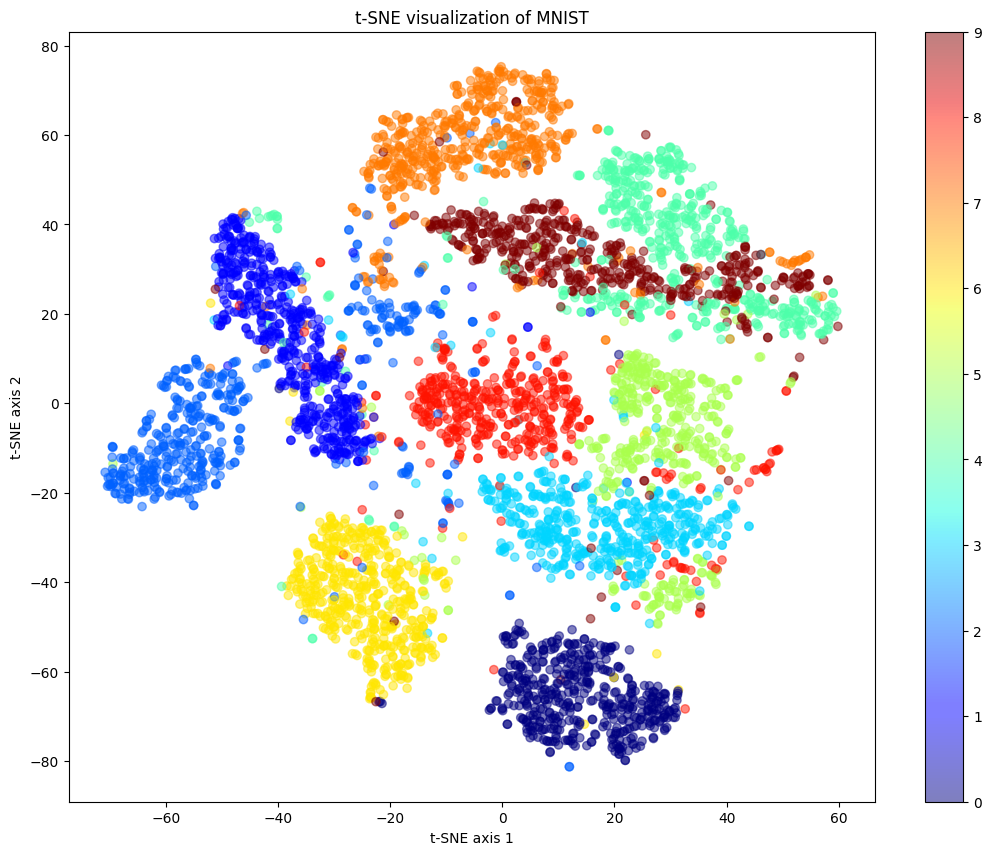

t-SNE computation took 49.86 seconds


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Take the first 5,000 images from the MNIST dataset
X_sample, y_sample = X_train[:5000], y_train[:5000]

# Use t-SNE to reduce dimensionality to 2 dimensions for visualization
tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=42)

# Time the t-SNE computation
start_time = time.time()
X_reduced_tsne = tsne.fit_transform(X_sample)
end_time = time.time()

# Plot the result of t-SNE
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=y_sample.astype(np.int), cmap="jet", alpha=0.5)
plt.colorbar()
plt.title('t-SNE visualization of MNIST')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.show()

# Print the time taken to compute t-SNE
print(f"t-SNE computation took {end_time - start_time:.2f} seconds")


The t-SNE visualization of a subset of the MNIST dataset forms distinct clusters that correspond well with the actual digits, suggesting that the data points for each digit occupy relatively compact and separate regions in the high-dimensional space. The color-coding of the scatter plot effectively illustrates these clusters, confirming the ability of t-SNE to facilitate the visualization of high-dimensional data in two dimensions. The computation time for t-SNE is fairly quick, taking about 49.86 seconds, which is reasonable for such a complex transformation on a subset of 5,000 samples.



# 5. Clustering on Faces Datase

The split is stratified to ensure that each set contains faces from all the different individuals in proportion to the whole dataset. We reserved 40 samples for the test set and 80 for the validation set. After this process, we are left with a training set of 280 samples, a validation set of 80 samples, and a test set of 40 samples, each retaining the original feature dimensionality of 4096.


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Splitting the dataset into training, validation, and test sets
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(faces.data, faces.target))
X_train_valid, y_train_valid = X_faces[train_valid_idx], y_faces[train_valid_idx]
X_test, y_test = X_faces[test_idx], y_faces[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train, y_train = X_train_valid[train_idx], y_train_valid[train_idx]
X_valid, y_valid = X_train_valid[valid_idx], y_train_valid[valid_idx]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_valid.shape}, {y_valid.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (280, 4096), (280,)
Validation set: (80, 4096), (80,)
Test set: (40, 4096), (40,)


These splits will help us to train our models on a diverse sample of the data and evaluate their performance effectively on unseen data.


Here, we apply PCA to reduce the dimensionality of our dataset while retaining 99% of the variance in the data. This helps to reduce computational costs and can improve the performance of clustering and classification algorithms by removing noise and redundant features.


In [ ]:
# Import the PCA module
from sklearn.decomposition import PCA

# Reduce dimensionality with PCA to retain 99% of variance
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

print(f"PCA components: {pca.n_components_}")


PCA components: 199


The PCA process reduces the number of features from 4096 to 199, which indicates that these 199 principal components capture most of the variation in the dataset. This is a significant reduction in dimensionality, allowing for more efficient computations in the subsequent steps.


We utilize the silhouette score, a measure of how similar an object is to its own cluster compared to other clusters, to determine the optimal number of clusters for K-Means. After testing a range of cluster sizes, we find that the optimal number of clusters for our dataset is 120, which is the number of clusters that results in the highest silhouette score.


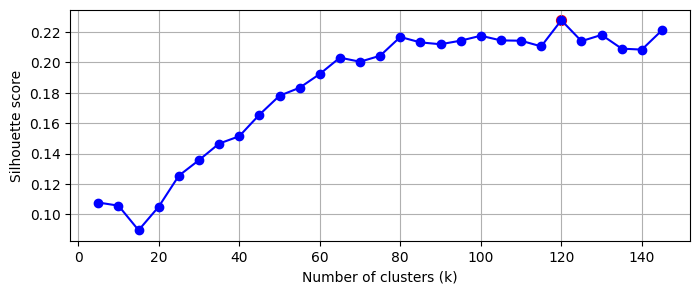

Best number of clusters: 120


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Finding the optimal number of clusters using silhouette score
k_range = range(5, 150, 5)
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_train_pca) for k in k_range]
silhouette_scores = [silhouette_score(X_train_pca, kmeans.labels_) for kmeans in kmeans_per_k]

best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

# Plotting silhouette scores
plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.scatter(best_k, best_score, c='red', s=50)
plt.grid(True)
plt.show()

print(f"Best number of clusters: {best_k}")


The silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.


Cluster: 0, Faces count: 3


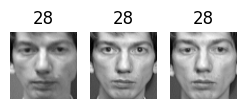

Cluster: 1, Faces count: 1


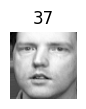

Cluster: 2, Faces count: 4


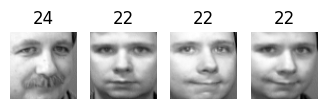

Cluster: 3, Faces count: 4


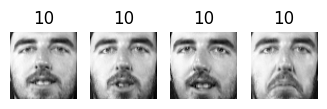

Cluster: 4, Faces count: 1


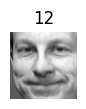

Cluster: 5, Faces count: 6


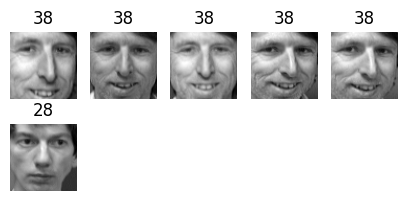

Cluster: 6, Faces count: 4


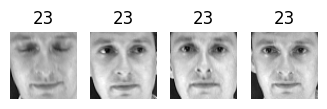

Cluster: 7, Faces count: 1


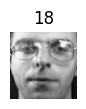

Cluster: 8, Faces count: 2


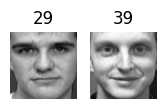

Cluster: 9, Faces count: 1


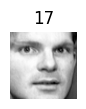

Cluster: 10, Faces count: 2


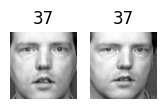

Cluster: 11, Faces count: 3


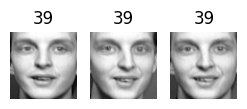

Cluster: 12, Faces count: 2


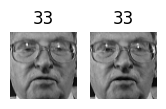

Cluster: 13, Faces count: 4


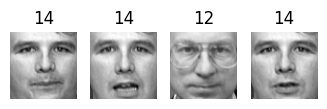

Cluster: 14, Faces count: 2


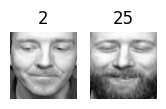

Cluster: 15, Faces count: 4


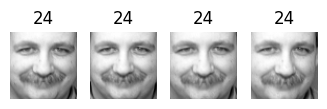

Cluster: 16, Faces count: 3


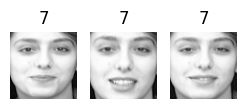

Cluster: 17, Faces count: 6


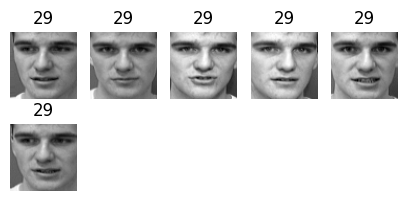

Cluster: 18, Faces count: 2


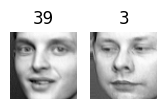

Cluster: 19, Faces count: 5


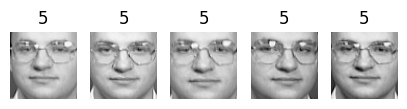

Cluster: 20, Faces count: 3


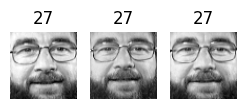

Cluster: 21, Faces count: 4


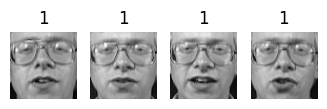

Cluster: 22, Faces count: 3


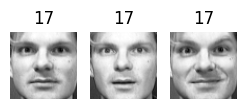

Cluster: 23, Faces count: 4


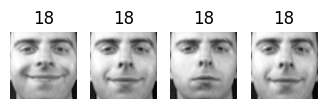

Cluster: 24, Faces count: 2


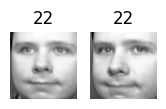

Cluster: 25, Faces count: 3


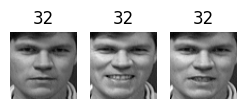

Cluster: 26, Faces count: 5


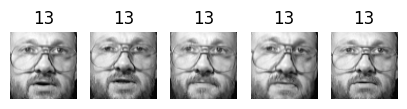

Cluster: 27, Faces count: 2


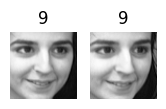

Cluster: 28, Faces count: 4


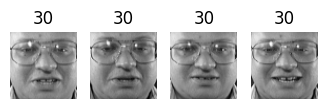

Cluster: 29, Faces count: 2


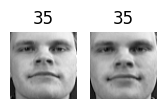

Cluster: 30, Faces count: 3


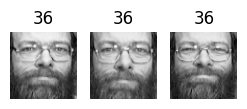

Cluster: 31, Faces count: 2


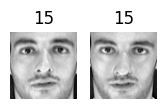

Cluster: 32, Faces count: 3


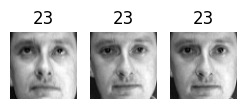

Cluster: 33, Faces count: 3


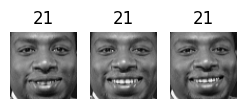

Cluster: 34, Faces count: 5


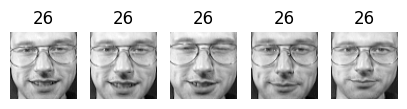

Cluster: 35, Faces count: 3


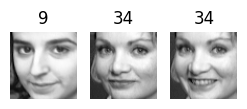

Cluster: 36, Faces count: 2


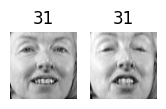

Cluster: 37, Faces count: 3


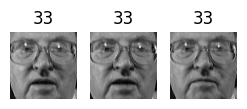

Cluster: 38, Faces count: 2


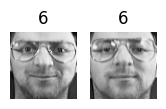

Cluster: 39, Faces count: 2


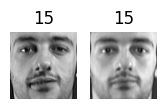

Cluster: 40, Faces count: 3


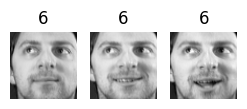

Cluster: 41, Faces count: 4


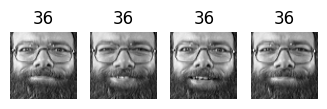

Cluster: 42, Faces count: 3


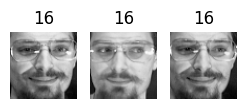

Cluster: 43, Faces count: 3


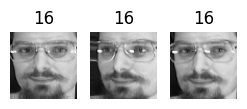

Cluster: 44, Faces count: 3


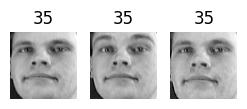

Cluster: 45, Faces count: 1


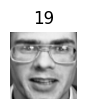

Cluster: 46, Faces count: 2


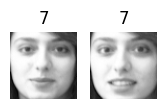

Cluster: 47, Faces count: 2


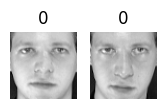

Cluster: 48, Faces count: 4


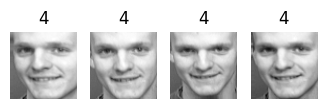

Cluster: 49, Faces count: 1


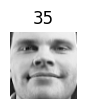

Cluster: 50, Faces count: 1


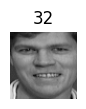

Cluster: 51, Faces count: 3


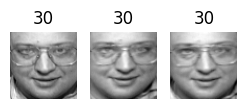

Cluster: 52, Faces count: 2


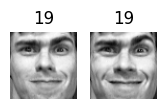

Cluster: 53, Faces count: 1


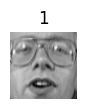

Cluster: 54, Faces count: 5


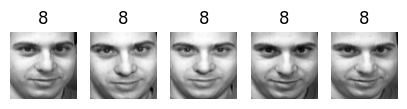

Cluster: 55, Faces count: 4


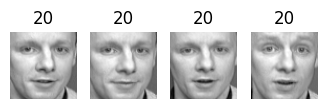

Cluster: 56, Faces count: 5


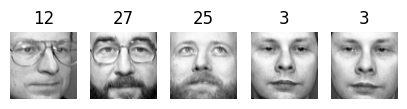

Cluster: 57, Faces count: 2


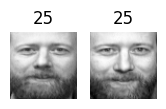

Cluster: 58, Faces count: 2


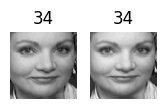

Cluster: 59, Faces count: 3


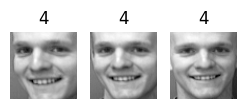

Cluster: 60, Faces count: 1


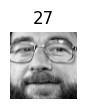

Cluster: 61, Faces count: 1


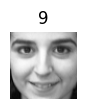

Cluster: 62, Faces count: 2


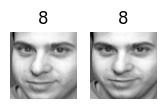

Cluster: 63, Faces count: 1


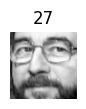

Cluster: 64, Faces count: 1


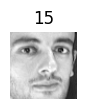

Cluster: 65, Faces count: 4


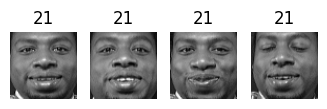

Cluster: 66, Faces count: 1


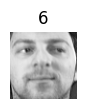

Cluster: 67, Faces count: 3


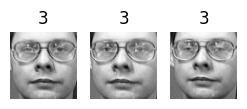

Cluster: 68, Faces count: 2


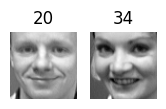

Cluster: 69, Faces count: 2


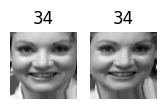

Cluster: 70, Faces count: 4


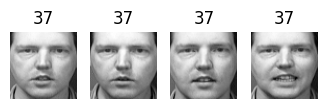

Cluster: 71, Faces count: 2


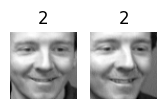

Cluster: 72, Faces count: 1


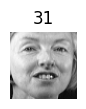

Cluster: 73, Faces count: 1


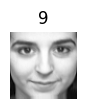

Cluster: 74, Faces count: 2


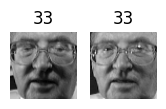

Cluster: 75, Faces count: 4


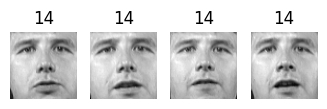

Cluster: 76, Faces count: 2


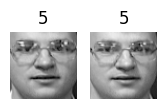

Cluster: 77, Faces count: 2


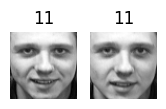

Cluster: 78, Faces count: 2


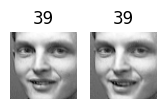

Cluster: 79, Faces count: 1


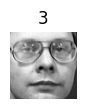

Cluster: 80, Faces count: 1


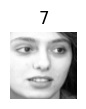

Cluster: 81, Faces count: 1


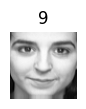

Cluster: 82, Faces count: 2


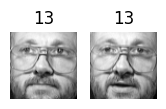

Cluster: 83, Faces count: 2


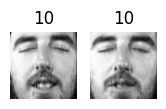

Cluster: 84, Faces count: 2


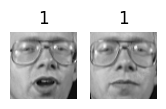

Cluster: 85, Faces count: 2


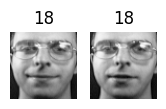

Cluster: 86, Faces count: 1


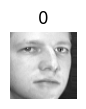

Cluster: 87, Faces count: 3


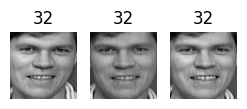

Cluster: 88, Faces count: 2


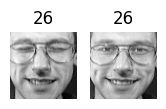

Cluster: 89, Faces count: 1


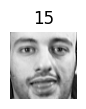

Cluster: 90, Faces count: 1


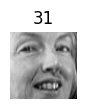

Cluster: 91, Faces count: 3


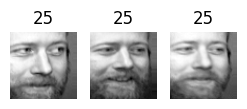

Cluster: 92, Faces count: 3


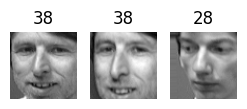

Cluster: 93, Faces count: 2


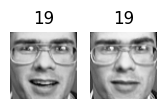

Cluster: 94, Faces count: 2


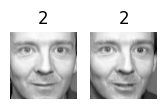

Cluster: 95, Faces count: 2


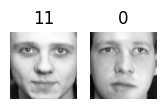

Cluster: 96, Faces count: 1


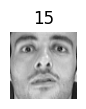

Cluster: 97, Faces count: 1


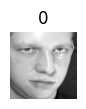

Cluster: 98, Faces count: 1


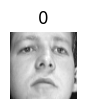

Cluster: 99, Faces count: 1


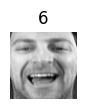

Cluster: 100, Faces count: 3


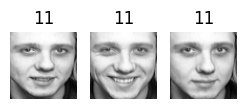

Cluster: 101, Faces count: 2


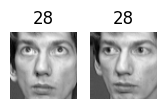

Cluster: 102, Faces count: 2


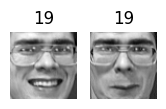

Cluster: 103, Faces count: 1


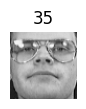

Cluster: 104, Faces count: 1


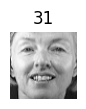

Cluster: 105, Faces count: 2


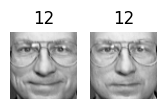

Cluster: 106, Faces count: 1


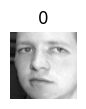

Cluster: 107, Faces count: 2


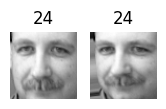

Cluster: 108, Faces count: 1


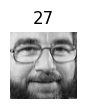

Cluster: 109, Faces count: 2


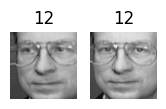

Cluster: 110, Faces count: 1


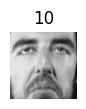

Cluster: 111, Faces count: 2


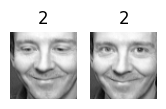

Cluster: 112, Faces count: 2


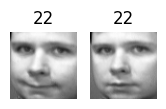

Cluster: 113, Faces count: 2


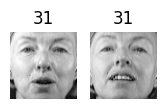

Cluster: 114, Faces count: 1


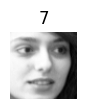

Cluster: 115, Faces count: 1


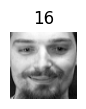

Cluster: 116, Faces count: 2


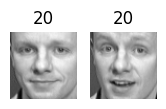

Cluster: 117, Faces count: 1


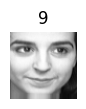

Cluster: 118, Faces count: 1


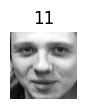

Cluster: 119, Faces count: 3


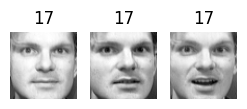

In [ ]:
def plot_faces(faces, labels, n_cols=5):
    # Function to plot a selection of faces
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

# Visualizing faces from the most representative cluster
best_model = kmeans_per_k[np.argmax(silhouette_scores)]
for cluster_id in np.unique(best_model.labels_):
    in_cluster = best_model.labels_ == cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    print(f"Cluster: {cluster_id}, Faces count: {len(faces)}")
    plot_faces(faces, labels)


In this experiment, we compare the performance of a RandomForestClassifier when trained on the original PCA-reduced features and when trained on the new feature space transformed by K-Means.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train a RandomForestClassifier on the original PCA-reduced data
clf_original = RandomForestClassifier(n_estimators=150, random_state=42)
clf_original.fit(X_train_pca, y_train)
original_score = clf_original.score(X_valid_pca, y_valid)
print(f"Validation score on original features: {original_score}")

# Train a RandomForestClassifier on the dataset reduced further by k-means
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf_reduced = RandomForestClassifier(n_estimators=150, random_state=42)
clf_reduced.fit(X_train_reduced, y_train)
reduced_score = clf_reduced.score(X_valid_reduced, y_valid)
print(f"Validation score on K-Means reduced features: {reduced_score}")


Validation score on original features: 0.925
Validation score on K-Means reduced features: 0.7


The validation scores reveal that the classifier performs better with the original PCA-reduced features (92.5% accuracy) compared to when using the K-Means reduced features (70% accuracy). This indicates that while K-Means provides a more compact representation, it may discard some information that is valuable for the classification task.


# 6. Anomaly Detection

In this section, we perform dimensionality reduction on the Olivetti faces dataset using PCA. A Gaussian Mixture Model (GMM) is then trained on this reduced dataset. Using the GMM, we sample new points in the reduced space, which correspond to new faces when transformed back to the original space using the inverse PCA transformation. The plot_faces function is used to visualize these new faces.



(400, 4096)
(400, 260)
260


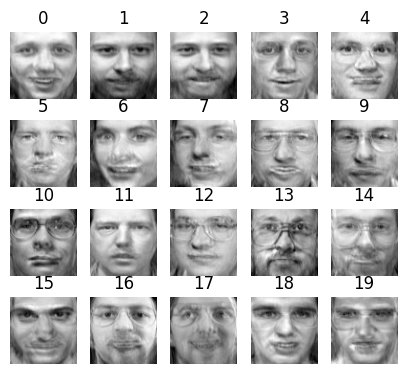

In [ ]:
# Import necessary libraries
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Load Olivetti faces dataset
faces_data = fetch_olivetti_faces(shuffle=True, random_state=42).data

# Apply PCA to reduce the dataset while preserving 99% of the variance
pca_olivetti = PCA(n_components=0.99, random_state=42)
faces_pca = pca_olivetti.fit_transform(faces_data)

# Train a Gaussian mixture model on the reduced dataset
gm = GaussianMixture(n_components=40, random_state=42)
gm.fit(faces_pca)

# Generate new faces using the trained model
n_new_faces = 20
new_faces_pca, _ = gm.sample(n_samples=n_new_faces)
new_faces = pca_olivetti.inverse_transform(new_faces_pca)

# Visualize the generated faces
plot_faces(new_faces, np.arange(n_new_faces))


In this section, we apply transformations to the Olivetti dataset to create anomalies such as rotations, flips, and darkened images. These transformed images are projected into the PCA space. We then use the trained Gaussian Mixture Model to detect anomalies based on a threshold derived from the score_samples method. Images with a score below the threshold are classified as anomalies. The calculate_gmm_scores function is introduced to encapsulate the scoring process, and we visualize and print the number of detected anomalies.



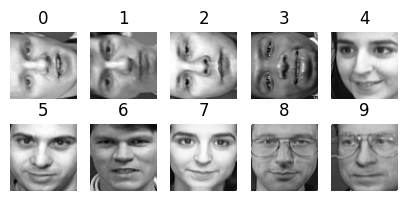

Number of anomalies detected: 10/10


In [ ]:
# Define transformations to introduce anomalies
def rotate_image(image):
    return np.transpose(image.reshape(64, 64), axes=[1, 0]).flatten()

def flip_image(image):
    return image.reshape(64, 64)[:, ::-1].flatten()

def darken_image(image):
    copy = image.copy()
    copy[1:-1] *= 0.3
    return copy.flatten()

# Introduce anomalies: rotate, flip, darken
rotated_faces = np.array([rotate_image(face) for face in faces_data[:4]])
flipped_faces = np.array([flip_image(face) for face in faces_data[4:7]])
darkened_faces = np.array([darken_image(face) for face in faces_data[7:10]])

# Combine the original and anomalous images
anomalous_faces = np.vstack([rotated_faces, flipped_faces, darkened_faces])

# Project the anomalous images into PCA space
anomalous_faces_pca = pca_olivetti.transform(anomalous_faces)

# Function to calculate the Gaussian Mixture score for a given dataset
def calculate_gmm_scores(gm_model, data):
    return gm_model.score_samples(data)

# Set a threshold for anomaly detection
threshold = np.percentile(calculate_gmm_scores(gm, faces_pca), 5)

# Detect anomalies using the threshold
anomalies = calculate_gmm_scores(gm, anomalous_faces_pca) < threshold

# Visualize the anomalies detected
plot_faces(anomalous_faces[anomalies], np.arange(sum(anomalies)))

# Print out the results of anomaly detection
print(f"Number of anomalies detected: {anomalies.sum()}/{len(anomalous_faces_pca)}")


Here, we define a function to compute the reconstruction errors of images when using PCA. By setting a threshold at the 95th percentile of the reconstruction errors for the original dataset, we can identify anomalous images whose reconstruction error exceeds this threshold. We then visualize these anomalies and print the count. This method assumes anomalies will have higher reconstruction errors due to their deviation from the normal data structure.



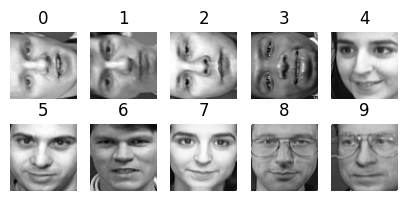

Number of anomalies detected using PCA: 10/10


In [ ]:
# Calculate reconstruction errors for a dataset
def reconstruction_errors(pca_model, data):
    data_pca = pca_model.transform(data)
    data_reconstructed = pca_model.inverse_transform(data_pca)
    mse = np.mean(np.square(data_reconstructed - data), axis=-1)
    return mse

# Compute reconstruction errors for the original and anomalous datasets
errors_original = reconstruction_errors(pca_olivetti, faces_data)
errors_anomalous = reconstruction_errors(pca_olivetti, anomalous_faces)

# Set a threshold for anomaly detection based on reconstruction error
threshold_pca = np.percentile(errors_original, 95)

# Detect anomalies using the reconstruction error threshold
anomalies_pca = errors_anomalous > threshold_pca

# Visualize the anomalies detected using PCA reconstruction error
plot_faces(anomalous_faces[anomalies_pca], np.arange(sum(anomalies_pca)))

# Print out the results of PCA-based anomaly detection
print(f"Number of anomalies detected using PCA: {anomalies_pca.sum()}/{len(anomalous_faces)}")
